In [1]:
import numpy as np
import pandas as pd

import random
import os
import py7zr
from tqdm import tqdm
from itertools import product

import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
import pickle
from sklearn.metrics import mean_squared_error

In [36]:
plt.style.use('dark_background')


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)

In [37]:
def read_cu_data(file_name):
    cu_data = pd.read_csv(file_name, sep=' ', header=None, skiprows=1)
    cu_data.columns = ['label', 'FileName']
    cu_data['FileName'] = cu_data['FileName'].apply(
        lambda x: str(x).split('.')[0] + '.mca')
    return cu_data

In [38]:
spectr_dir = 'spectrums'
cu_conc_file = 'Cu_conc.txt'
elements_file = 'elements.txt'

In [39]:
conc_data = read_cu_data('Cu_conc.txt')
conc_data.head()

,label,FileName
0,19.23,7282_01_07_2024.mca
1,18.54,7296_02_07_2024.mca
2,19.60,7310_03_07_2024.mca
3,16.48,7311_03_07_2024.mca
4,17.01,7328_04_07_2024.mca


In [40]:
elements = pd.read_csv(elements_file, sep=' ', header=None,
                       names=['element', 'start', 'end'])
elements.head()

,element,start,end
0,S,81,87
1,Ag,105,113
2,Cr,195,201
3,Fe_Ka,227,244
4,Fe_Kb,252,267


In [41]:
def parse_mca(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        lines = f.readlines()
        data_start = False
        spectrum = []
        real_time = None

        for line in lines:
            stripped_line = line.strip()
            if stripped_line.startswith("REAL_TIME - "):
                try:
                    real_time = float(stripped_line.split("-")[1].strip())
                except ValueError:
                    pass
            if data_start:
                if stripped_line == "<<END>>":
                    break
                try:
                    spectrum.append(int(stripped_line))
                except ValueError:
                    continue
            if stripped_line == "<<DATA>>":
                data_start = True

        return np.array(spectrum), real_time

In [42]:
def create_data_frame(cu_data, spectr_dir):
    spectra = {}
    times = {}
    for filename in cu_data['FileName']:
        filepath = os.path.join(spectr_dir, filename)
        if os.path.exists(filepath):
            spec, real_time = parse_mca(filepath)
            if spec is not None and real_time is not None:
                spectra[filename] = spec
                times[filename] = real_time

    df = cu_data.copy()
    df['spectrum_arr'] = df['FileName'].map(spectra)
    df['time'] = df['FileName'].map(times)

    df = df.dropna(subset=['spectrum_arr', 'time'])

    for index, row in elements.iterrows():
        element = row['element']
        ch1 = row['start']
        ch2 = row['end']
        df[element] = df.apply(
            lambda row: np.sum(row['spectrum_arr'][ch1:ch2+1]) / row['time']
            if ch1 < len(row['spectrum_arr']) and ch2 < len(row['spectrum_arr']) else 0,
            axis=1
        )
    return df

In [43]:
df = create_data_frame(conc_data, spectr_dir)
df = df.drop(['FileName', 'spectrum_arr', 'time', 'S', 'Ag', 'Cr', 'Kr', 'Ar_Kb', 'Ti',
             'Ca_Ka', 'Pb_Lb', 'Ni_kb', 'Ni_Ka', 'Fe_Kb', 'Pb_La', 'Zn_Ka', 'Zn_Kb', 'Fe_Ka'], axis=1)
df.head(5)

,label,Cu_Ka,Cu_Kb,Nkr
0,19.23,1813.612583,268.323667,1467.731960
1,18.54,1524.358268,226.414149,1729.328457
2,19.60,1582.066081,232.321205,1677.289837
3,16.48,1451.553044,217.091845,1577.986559
4,17.01,1223.458461,183.280710,2071.735244


In [44]:
feature_columns = df.columns.difference(['label'])
feature_columns

Index(['Cu_Ka', 'Cu_Kb', 'Nkr'], dtype='object')

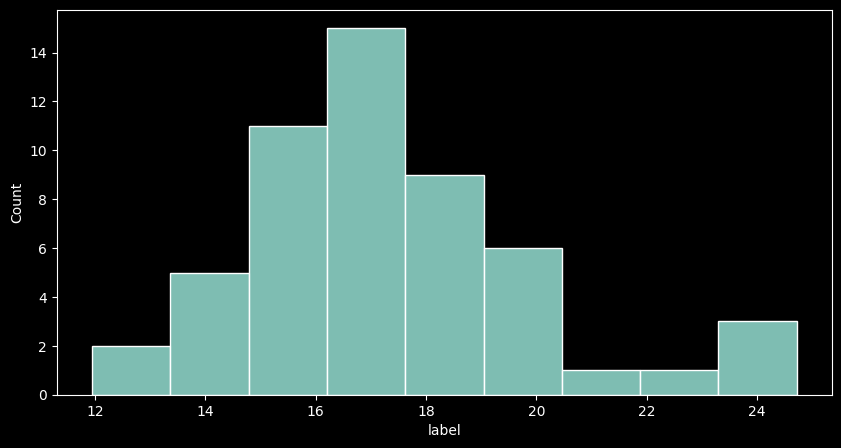

In [45]:
plt.figure(figsize=(10, 5))
sns.histplot(df['label'], alpha=.9)
plt.show()

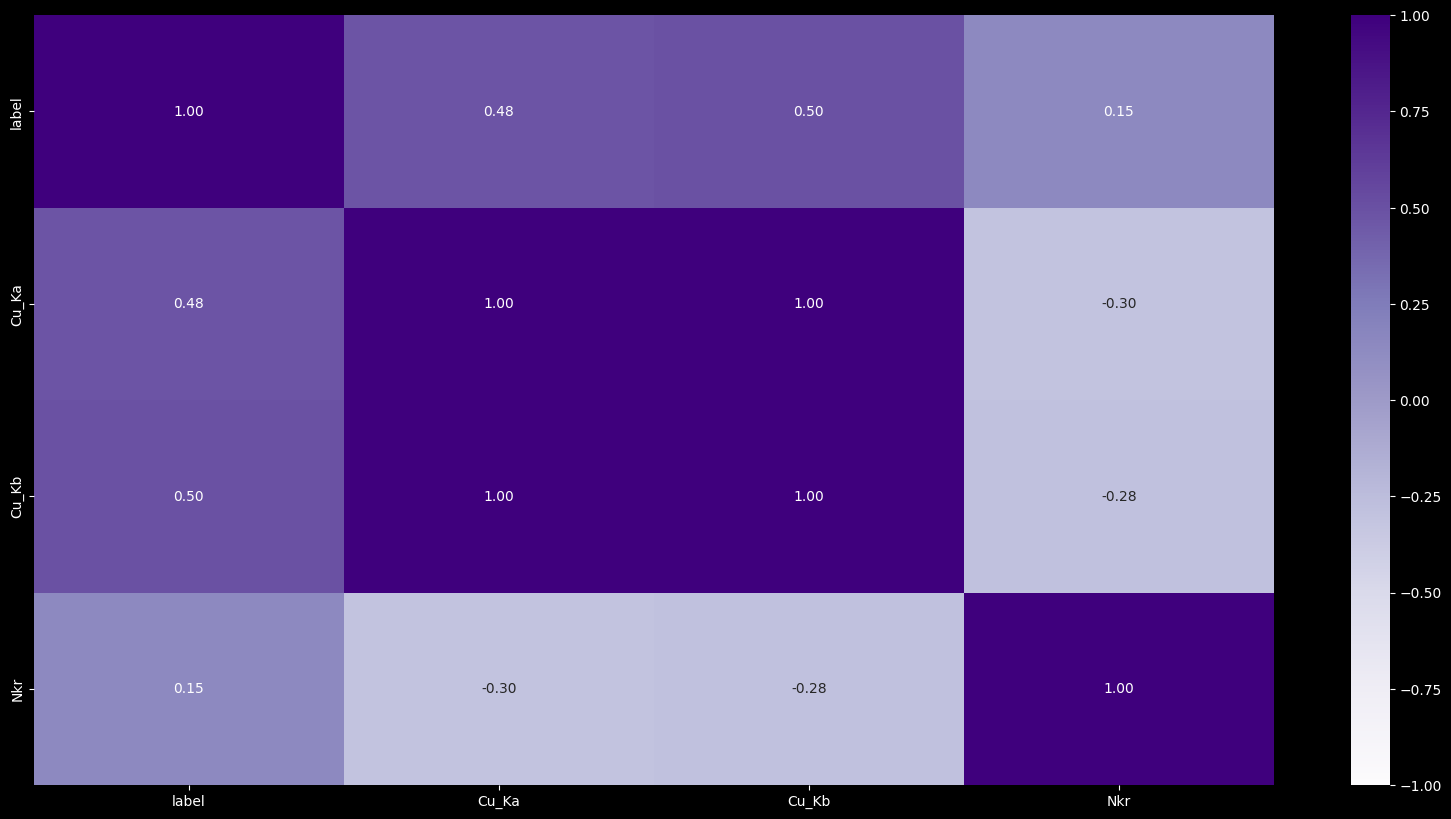

In [46]:
correlation_matrix = df.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True,
            cmap='Purples', fmt='.2f', vmin=-1, vmax=1)
plt.show()

$x_{scaled} = \frac{x-x_{min}}{x_{max} - x_{min}}$

In [47]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = df[feature_columns]
y = df['label']

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.0001, random_state=7)

In [49]:
def create_train_data(X_train, X_test, y_train, y_test):
    train_data = [(np.array(x).reshape(-1, 1), y)
                  for x, y in zip(X_train.tolist(), y_train.tolist())]

    test_data = [(np.array(x).reshape(-1, 1), y)
                 for x, y in zip(X_test.tolist(), y_test.tolist())]

    return train_data, test_data

In [50]:
train_data, test_data = create_train_data(X_train, X_test, y_train, y_test)

In [69]:
def create_train(X, Y):
    train_data = [(np.array(x).reshape(-1, 1), y)
                  for x, y in zip(X.tolist(), Y.tolist())]

    return train_data

In [70]:
X = df[feature_columns]
y = df['label']

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

KeyError: 'label'

In [ ]:
train_data = create_train(X_scaled1, y_scaled)

In [51]:
class Network(object):
    def __init__(self, sizes):
        set_seed(42)
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        set_seed(42)
        n = len(training_data)
        epoch_train_losses = []
        epoch_test_rmse = []
        epoch_test_r2 = []

        def calculate_r2(test_data):
            actual = []
            predicted = []
            for x, y in test_data:
                actual.append(y)
                predicted.append(self.feedforward(x))
            actual = np.array(actual).flatten()
            predicted = np.array(predicted).flatten()
            ss_total = np.sum((actual - np.mean(actual)) ** 2)
            ss_residual = np.sum((actual - predicted) ** 2)
            return 1 - (ss_residual / ss_total)

        with tqdm(range(epochs), desc="Training Progress") as pbar:
            for j in pbar:
                random.shuffle(training_data)
                mini_batches = [training_data[k:k + mini_batch_size]
                                for k in range(0, n, mini_batch_size)]
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, eta)

                epoch_train_loss = self.calculate_loss(training_data)
                epoch_train_losses.append(epoch_train_loss)

                if test_data:
                    epoch_rmse = self.calculate_rmse(test_data)
                    epoch_r2 = calculate_r2(test_data)
                    epoch_test_rmse.append(epoch_rmse)
                    epoch_test_r2.append(epoch_r2)

                    pbar.set_postfix(
                        train_loss=f"{epoch_train_loss:.4f}",
                        test_rmse=f"{epoch_rmse:.4f}",
                        test_r2=f"{epoch_r2:.4f}"
                    )
                else:
                    pbar.set_postfix(train_loss=f"{epoch_train_loss:.4f}")

        return epoch_train_losses, epoch_test_rmse, epoch_test_r2

    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (eta / len(mini_batch)) *
                        nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b,
                       nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        delta = self.cost_derivative(
            activations[-1], y) * self.sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.sigmoid_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        return (output_activations - y)

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def calculate_loss(self, data):
        loss = 0
        for x, y in data:
            output = self.feedforward(x)
            loss += np.sum((output - y) ** 2)
        return loss / len(data)

    def calculate_rmse(self, test_data):
        actual = []
        predicted = []
        for x, y in test_data:
            actual.append(y)
            predicted.append(self.feedforward(x))
        actual = np.array(actual).flatten()
        predicted = np.array(predicted).flatten()
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        return rmse

    def calculate_r2(self, test_data):
        actual = []
        predicted = []
        for x, y in test_data:
            actual.append(y)
            predicted.append(self.feedforward(x))
        actual = np.array(actual).flatten()
        predicted = np.array(predicted).flatten()
        ss_residual = np.sum((actual - predicted) ** 2)
        ss_total = np.sum((actual - np.mean(actual)) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

In [52]:
def plot_rmse(train_losses, test_rmse=None):
    test_rmse2 = [x ** 2 for x in test_rmse]
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    if test_rmse:
        plt.plot(range(1, len(test_rmse) + 1), test_rmse2,
                 label='test', linestyle='dashed')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()

In [53]:
def get_predictions(model, test_data, scaler):
    predictions = []
    for x, _ in test_data:
        predictions.append(model.feedforward(x))

    predictions = scaler.inverse_transform(
        np.array(predictions).reshape(-1, 1))
    return predictions


def plot_predictions(test_data, predictions, scaler):
    true_values = [y for _, y in test_data]

    true_values = scaler.inverse_transform(
        np.array(true_values).reshape(-1, 1))

    predicted_values = predictions.flatten()

    r2 = r2_score(true_values, predicted_values)

    plt.figure(figsize=(10, 6))

    plt.plot(range(len(test_data)), true_values, label='True Values',
             color='blue', marker='o', linestyle='-', markersize=6)
    plt.plot(range(len(test_data)), predicted_values, label='Predictions',
             color='red', marker='s', linestyle='--', markersize=6)

    plt.xlabel('Object')
    plt.ylabel('Concentration')
    plt.legend()
    plt.grid(True)

    plt.show()

    print(f'R^2 = {r2:.2f}')

In [54]:
net = Network([len(feature_columns), 4, 4, 1])

Training Progress:   0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\sm636\AppData\Local\Temp\ipykernel_25580\2887721281.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (ss_residual / ss_total)
Training Progress:   0%|          | 0/4000 [00:00<?, ?it/s, test_r2=-inf, test_rmse=0.2127, train_loss=0.0432]C:\Users\sm636\AppData\Local\Temp\ipykernel_25580\2887721281.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (ss_residual / ss_total)
Training Progress:   0%|          | 0/4000 [00:00<?, ?it/s, test_r2=-inf, test_rmse=0.2855, train_loss=0.0429]C:\Users\sm636\AppData\Local\Temp\ipykernel_25580\2887721281.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - (ss_residual / ss_total)
Training Progress:   0%|          | 0/4000 [00:00<?, ?it/s, test_r2=-inf, test_rmse=0.2502, train_loss=0.0416]C:\Users\sm636\AppData\Local\Temp\ipykernel_25580\2887721281.py:32: RuntimeWarning: divide by zero encountered in

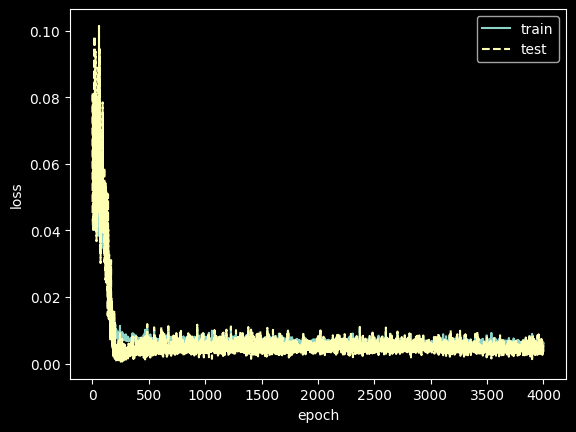

In [55]:
train_loss, test_rmse, test_r = net.SGD(
    train_data, epochs=4000, mini_batch_size=1, eta=0.5, test_data=test_data)
plot_rmse(train_loss, test_rmse)

c:\Users\sm636\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


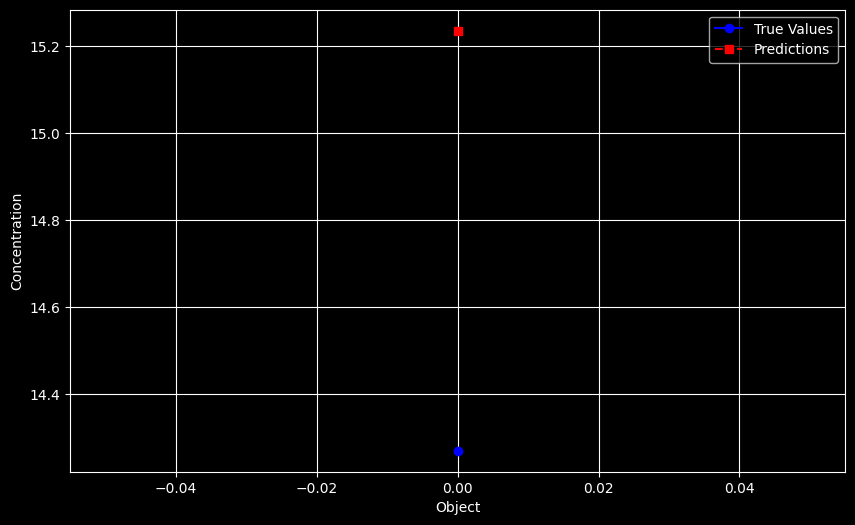

R^2 = nan


In [56]:
predictions = get_predictions(net, test_data, scaler_y)
plot_predictions(test_data, predictions, scaler_y)

In [66]:
def create_train(X, Y):
    train_data = [(np.array(x).reshape(-1, 1), y)
                  for x, y in zip(X.tolist(), Y.tolist())]

    return train_data

In [68]:
df.head()\

,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,12.658863,11.906355,5.936455,1312.408027,262.742475,5.886288,7.658863,19.899666,20.050167,1406.103679,210.317726,822.809365,146.187291,88.745819,115.869565,7.943144,1515.250836,314.882943
1,11.423326,11.355330,6.238632,1182.994203,245.312527,5.507675,8.329509,22.370680,23.407619,1844.442178,272.884900,928.706206,154.673874,87.748823,123.276727,7.683547,1492.681932,310.401686
2,15.235804,14.049683,6.131075,723.065871,148.649326,7.166842,8.403081,24.741476,18.710637,1223.458461,183.280710,672.313270,120.082193,81.742094,135.234468,5.512955,2071.735244,405.853756
3,10.559322,11.084746,5.847458,1600.033898,318.033898,5.271186,7.355932,20.677966,25.711864,1984.779661,289.610169,1394.542373,221.050847,99.084746,128.067797,8.677966,1174.508475,260.152542
4,14.958264,13.472454,5.375626,935.642738,189.549249,6.928214,8.247078,24.123539,21.151920,1169.866444,174.273790,920.317195,162.721202,84.173623,133.906511,7.312187,1831.135225,372.487479


In [67]:
X = df[feature_columns]
y = df['label']

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

KeyError: 'label'

In [ ]:
train_data = create_train(X_scaled, y_scaled)

# проверка

In [57]:
spectrums1_dir = 'spectrums1'

In [58]:
data = pd.DataFrame([x for x in range(1, 19)])

In [59]:
data.columns = ['FileName']
data['FileName'] = data['FileName'].apply(
    lambda x: str(x).split('.')[0] + '.mca')
data.head()

,FileName
0,1.mca
1,2.mca
2,3.mca
3,4.mca
4,5.mca


In [60]:
df = create_data_frame(data, spectrums1_dir)

In [61]:
df = df.drop(['FileName', 'spectrum_arr', 'time'], axis=1)
df.head(2)

,S,Ag,Cr,Fe_Ka,Fe_Kb,Ar_Kb,Ca_Ka,Ni_Ka,Ni_kb,Cu_Ka,Cu_Kb,Zn_Ka,Zn_Kb,Pb_La,Pb_Lb,Ti,Nkr,Kr
0,12.658863,11.906355,5.936455,1312.408027,262.742475,5.886288,7.658863,19.899666,20.050167,1406.103679,210.317726,822.809365,146.187291,88.745819,115.869565,7.943144,1515.250836,314.882943
1,11.423326,11.355330,6.238632,1182.994203,245.312527,5.507675,8.329509,22.370680,23.407619,1844.442178,272.884900,928.706206,154.673874,87.748823,123.276727,7.683547,1492.681932,310.401686


In [62]:
X = df[feature_columns]
X_scaled = scaler_X.fit_transform(X)

In [63]:
test = [np.array(x).reshape(-1, 1) for x in X_scaled.tolist()]

In [64]:
y_preds = [net.feedforward(x) for x in test]


y_preds = scaler_y.inverse_transform(
    np.array(y_preds).reshape(-1, 1))

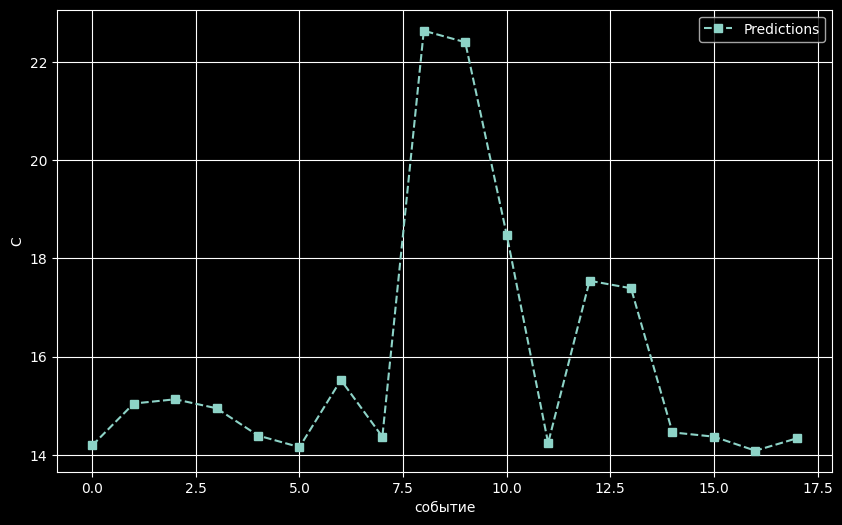

In [65]:
preds_values = y_preds.flatten()

plt.figure(figsize=(10, 6))

plt.plot(range(len(test)), preds_values, label='Predictions',
         marker='s', linestyle='--', markersize=6)

plt.xlabel('событие')
plt.ylabel('C')
plt.legend()
plt.grid(True)
plt.show()

In [109]:
y_preds

array([[13.75300282],
       [14.31068671],
       [14.07770028],
       [14.30528933],
       [13.81262395],
       [13.74604911],
       [14.58249165],
       [13.80676286],
       [15.25025426],
       [18.6474669 ],
       [17.65402906],
       [13.81762145],
       [15.68675735],
       [15.67736938],
       [13.86709466],
       [13.78260981],
       [13.73507803],
       [14.00140628]])